In [ ]:
# Cell 1: Setup and Installs
!pip install sentence-transformers pandas scikit-learn tensorflow matplotlib

import pandas as pd
import numpy as np
import ast
import io
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.metrics import (
    classification_report, accuracy_score, hamming_loss,
    jaccard_score, precision_recall_fscore_support
)
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

tf.random.set_seed(42)
np.random.seed(42)
print("Libraries installed and imported.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
# Cell 2: Load Data from Colab Filesystem
import pandas as pd

file_path = '/content/English_long_formatted.csv'
# Make sure English_long_formatted.csv is uploaded to /content/

try:
    df_original = pd.read_csv(file_path) # Load into a new df name to keep it fresh
    print(f"Successfully loaded '{file_path}'")
except FileNotFoundError:
    print(f"ERROR: File not found at '{file_path}'. Upload it first.")
    df_original = pd.DataFrame()

if not df_original.empty:
    if 'Unnamed: 0' in df_original.columns:
        df_original = df_original.drop(columns=['Unnamed: 0'])
    elif df_original.columns[0] == '' and len(df_original.columns) > 1:
        df_original = df_original.rename(columns={'': 'original_index'}).drop(columns=['original_index'])

    df = df_original.copy() # Work with a copy for this notebook's specific preprocessing
    print("\nDataFrame Head:")
    print(df.head(2))
    print("\nDataFrame Info:")
    df.info()
else:
    print("\nDataFrame is empty.")

Successfully loaded '/content/English_long_formatted.csv'

DataFrame Head:
              Scenario_id              Annotator_id  \
0  long_id_0_MJI_Emotions  6600f13d42341b1aae3e20ae   
1  long_id_0_MJI_Emotions  5db31089a1f8d3000c10a6c5   

                                            Scenario  \
0  A manager is considering two candidates for a ...   
1  A manager is considering two candidates for a ...   

                                    Possible_actions  Selected_action  \
0  ['Promote the Highly Qualified Candidate, pote...                2   
1  ['Promote the Highly Qualified Candidate, pote...                2   

                                              Reason  \
0  You can train this employee on necessary skill...   
1  The potential for disruption to the workforce ...   

                                         Consequence       Action_criteria  \
0  The outspoken employee will likely be very ups...  ['2', '4', '4', '5']   
1  The need for skill development will probab

In [ ]:
# Cell 3: Initial Preprocessing (Parsing Lists, Target Variable Preparation)

def safe_literal_eval_new(val):
    try:
        return ast.literal_eval(val)
    except:
        return val

if not df.empty:
    df['Possible_actions'] = df['Possible_actions'].apply(safe_literal_eval_new)
    df['Contributing_emotion'] = df['Contributing_emotion'].apply(safe_literal_eval_new)
    df['Moral_values_dict'] = df['Moral_values'].apply(safe_literal_eval_new)
    df['Cultural_values_dict'] = df['Cultural_values'].apply(safe_literal_eval_new)

    # --- Target Variable 1: Selected_action_binary ---
    # Original is 1 or 2, convert to 0 or 1
    df['Selected_action_binary'] = df['Selected_action'].apply(lambda x: x - 1)

    # --- Target Variable 2: Contributing_emotion ---
    # Handle 'None' and ensure it's a list of strings
    def process_emotions(emotions_list):
        if isinstance(emotions_list, list):
            # Filter out 'None' string if it's the only element or among others
            cleaned_emotions = [str(e) for e in emotions_list if str(e).lower() != 'none' and pd.notna(e)]
            return cleaned_emotions if cleaned_emotions else ['no_emotion_stated'] # Use a placeholder if empty
        elif pd.isna(emotions_list) or str(emotions_list).lower() == 'none':
            return ['no_emotion_stated'] # Placeholder for NaN or 'None' string
        return [str(emotions_list)] # If it's a single string emotion

    df['Contributing_emotion_list'] = df['Contributing_emotion'].apply(process_emotions)

    # Fit MultiLabelBinarizer for emotions
    mlb_emotion = MultiLabelBinarizer()
    y_emotion_encoded = mlb_emotion.fit_transform(df['Contributing_emotion_list'])
    emotion_target_cols = mlb_emotion.classes_.tolist()
    print(f"Emotion classes for MLB: {emotion_target_cols}")

    # Add encoded emotions back to df for easier splitting (optional, could also keep y_emotion_encoded separate)
    for i, emotion_col in enumerate(emotion_target_cols):
        df[f"emotion_{emotion_col}"] = y_emotion_encoded[:, i]

    # Create Selected_action_text (will be an input feature)
    df['Selected_action_text'] = df.apply(
        lambda row: row['Possible_actions'][row['Selected_action_binary']] # Use 0-indexed binary action
        if isinstance(row['Possible_actions'], list) and 0 <= row['Selected_action_binary'] < len(row['Possible_actions'])
        else "",
        axis=1
    )

    # Text features for embedding (common to all 3 models)
    text_input_cols = ['Scenario', 'Selected_action_text', 'Annotator_self_description']
    for col in text_input_cols:
        df[col] = df[col].fillna("").astype(str)

    # Numerical Moral Values (for Models 2 & 3)
    moral_value_keys = ['Care', 'Equality', 'Proportionality', 'Loyalty', 'Authority', 'Purity']
    for key in moral_value_keys:
        df[f'moral_{key}'] = df['Moral_values_dict'].apply(lambda x: x.get(key, np.nan) if isinstance(x, dict) else np.nan)

    # Numerical Cultural Values (for Model 3)
    cultural_value_keys = ['Power Distance', 'Individualism', 'Masculinity', 'Uncertainty Avoidance', 'Long Term Orientation', 'Indulgence vs Restraint']
    for key in cultural_value_keys:
        df[f'cultural_{key}'] = df['Cultural_values_dict'].apply(lambda x: x.get(key, np.nan) if isinstance(x, dict) else np.nan)

    # --- Define target columns ---
    target_action_col = ['Selected_action_binary']
    target_emotion_cols = [f"emotion_{col}" for col in emotion_target_cols]

    # --- Handle potential NaNs introduced by parsing moral/cultural values if dicts were incomplete ---
    cols_to_check_for_nan_inputs = [f'moral_{k}' for k in moral_value_keys] + [f'cultural_{k}' for k in cultural_value_keys]
    df_cleaned = df.dropna(subset=cols_to_check_for_nan_inputs).copy() # Drop rows if any MORAL/CULTURAL input is NaN
                                                                     # Assuming targets (action/emotion) are always present
    print(f"Shape of df after parsing and initial NaN drop (if any from moral/cultural inputs): {df_cleaned.shape}")

    df = df_cleaned # Work with the cleaned dataframe

    print(df[['Scenario_id', 'Selected_action_binary'] + target_emotion_cols].head())
else:
    print("DataFrame is empty, skipping preprocessing.")

Emotion classes for MLB: ['Anger', 'Anticipation', 'Disgust', 'Fear', 'Joy', 'Sadness', 'Surprise', 'Trust', 'no_emotion_stated', 'scale_1', 'scale_2', 'scale_3', 'scale_4', 'scale_5']
Shape of df after parsing and initial NaN drop (if any from moral/cultural inputs): (582, 44)
              Scenario_id  Selected_action_binary  emotion_Anger  \
0  long_id_0_MJI_Emotions                       1              0   
1  long_id_0_MJI_Emotions                       1              0   
2  long_id_0_MJI_Emotions                       0              0   
3            Reddit_id_50                       1              0   
4            Reddit_id_50                       0              0   

   emotion_Anticipation  emotion_Disgust  emotion_Fear  emotion_Joy  \
0                     0                0             0            0   
1                     1                0             0            0   
2                     1                0             0            1   
3                     1     

In [ ]:
# Cell 4: Initialize Embedding Model
embedding_model_name = 'all-MiniLM-L6-v2'
sbert_model = SentenceTransformer(embedding_model_name)
print(f"Sentence Transformer model '{embedding_model_name}' loaded.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Sentence Transformer model 'all-MiniLM-L6-v2' loaded.


In [ ]:
# Cell 5: Generate Text Embeddings (Common for all models)

if not df.empty:
    embeddings_list_text = []
    for col in text_input_cols:
        print(f"Generating embeddings for: {col}")
        texts_to_embed = df[col].astype(str).tolist()
        embeddings = sbert_model.encode(texts_to_embed, show_progress_bar=True)
        embeddings_list_text.append(embeddings)

    X_text_embeddings = np.concatenate(embeddings_list_text, axis=1)
    print(f"\nShape of X_text_embeddings: {X_text_embeddings.shape}")
else:
    X_text_embeddings = np.array([])
    print("Skipping embedding generation as DataFrame is empty.")

Generating embeddings for: Scenario


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Selected_action_text


Batches:   0%|          | 0/19 [00:00<?, ?it/s]

Generating embeddings for: Annotator_self_description


Batches:   0%|          | 0/19 [00:00<?, ?it/s]


Shape of X_text_embeddings: (582, 1152)


## Model 1

In [ ]:
# Cell 6: Prepare Data for Model 1

if not df.empty:
    # Model 1 Inputs: Just text embeddings
    X_model1 = X_text_embeddings

    # Model 1 Targets
    y_action_model1 = df[target_action_col].values
    y_emotion_model1 = df[target_emotion_cols].values # These are already binarized

    print("Model 1 Data Shapes:")
    print(f"X_model1 shape: {X_model1.shape}")
    print(f"y_action_model1 shape: {y_action_model1.shape}")
    print(f"y_emotion_model1 shape: {y_emotion_model1.shape}")

    X_train1, X_test1, y_train_action1, y_test_action1, y_train_emotion1, y_test_emotion1 = train_test_split(
        X_model1, y_action_model1, y_emotion_model1, test_size=0.2, random_state=42
    )
else:
    print("DataFrame empty, skipping Model 1 data prep.")

Model 1 Data Shapes:
X_model1 shape: (582, 1152)
y_action_model1 shape: (582, 1)
y_emotion_model1 shape: (582, 14)


In [ ]:
# Cell 7: Build and Train Model 1 (Action Prediction Only)

if not df.empty:
    input_dims_model1 = X_train1.shape[1]

    # --- MODEL ARCHITECTURE (SINGLE OUTPUT) ---
    input_layer1 = Input(shape=(input_dims_model1,), name='input_model1')
    x = Dense(128, activation='relu', name='shared_dense1_m1')(input_layer1)
    x = Dropout(0.3, name='shared_dropout1_m1')(x)
    x = Dense(64, activation='relu', name='shared_dense2_m1')(x)
    x = Dropout(0.3, name='shared_dropout2_m1')(x)

    # --- ONLY THE ACTION OUTPUT HEAD ---
    output_action1 = Dense(1, activation='sigmoid', name='action_output_m1')(x)

    model1 = Model(inputs=input_layer1, outputs=output_action1, name="Model1_Action_Prediction")

    # --- COMPILE FOR SINGLE OUTPUT ---
    model1.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy', # Single loss function
        metrics=['accuracy']
    )
    model1.summary()

    print("\nTraining Model 1 (Action Prediction Only)...")
    early_stopping1 = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', # Now monitoring the main validation loss
        patience=10,
        restore_best_weights=True,
        mode='min'
    )

    # --- FIT FOR SINGLE OUTPUT ---
    history1 = model1.fit(
        X_train1,
        y_train_action1, # Pass only the action target
        epochs=50,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stopping1],
        verbose=1
    )
else:
    print("DataFrame empty, skipping Model 1 training.")

Model: "Model1_Action_Prediction"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_model1 (InputLayer)       │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense1_m1 (Dense)        │ (None, 128)            │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout1_m1 (Dropout)    │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense2_m1 (Dense)        │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout2_m1 (Dropout)    │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ action_output_m1 (Dense)        │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 155,905 (609.00 KB)

 Trainable params: 155,905 (609.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Model 1 (Action Prediction Only)...
Epoch 1/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5232 - loss: 0.6912 - val_accuracy: 0.4857 - val_loss: 0.6831
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6723 - loss: 0.6458 - val_accuracy: 0.6143 - val_loss: 0.6522
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7679 - loss: 0.6018 - val_accuracy: 0.6000 - val_loss: 0.6230
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7644 - loss: 0.5395 - val_accuracy: 0.6714 - val_loss: 0.5852
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7888 - loss: 0.4698 - val_accuracy: 0.6571 - val_loss: 0.5592
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8450 - loss: 0.4076 - val_accuracy: 0.6714 - val_loss: 0.5301
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8613 - loss: 0.3606 - val_accuracy: 0.7143 - val_loss: 0.5257
Epoch 8/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.


Evaluating Model 1 (Action Prediction Only)...
Model 1 - Test Loss: 0.6586, Test Accuracy: 0.7179
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

Model 1 - Action Classification Report:
              precision    recall  f1-score   support

    Action 0       0.74      0.70      0.72        60
    Action 1       0.70      0.74      0.72        57

    accuracy                           0.72       117
   macro avg       0.72      0.72      0.72       117
weighted avg       0.72      0.72      0.72       117



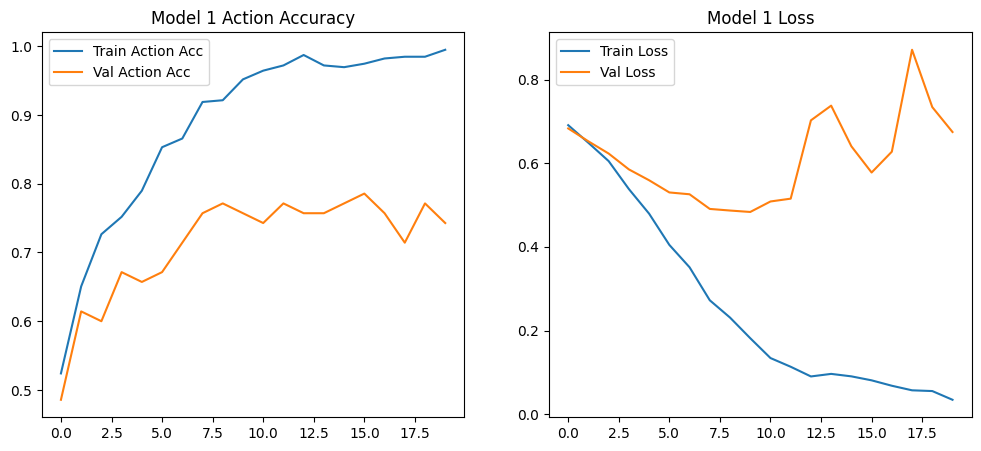

In [ ]:
# Cell 8: Evaluate Model 1 (Action Prediction Only)

if not df.empty and 'model1' in locals():
    print("\nEvaluating Model 1 (Action Prediction Only)...")
    loss1, accuracy1 = model1.evaluate(
        X_test1,
        y_test_action1,
        verbose=0
    )
    print(f"Model 1 - Test Loss: {loss1:.4f}, Test Accuracy: {accuracy1:.4f}")

    # Detailed classification report for action
    y_pred_action1_probs = model1.predict(X_test1)
    y_pred_action1_classes = (y_pred_action1_probs > 0.5).astype(int)
    print("\nModel 1 - Action Classification Report:")
    print(classification_report(y_test_action1, y_pred_action1_classes, target_names=['Action 0', 'Action 1']))

    # Plotting
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['accuracy'], label='Train Action Acc')
    plt.plot(history1.history['val_accuracy'], label='Val Action Acc')
    plt.title('Model 1 Action Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['loss'], label='Train Loss')
    plt.plot(history1.history['val_loss'], label='Val Loss')
    plt.title('Model 1 Loss')
    plt.legend()
    plt.show()
else:
    print("Skipping Model 1 evaluation.")

## Model 2

In [ ]:
# Cell 9: Prepare Data for Model 2

if not df.empty:
    moral_input_cols = [f'moral_{key}' for key in moral_value_keys]
    X_moral_features_raw = df[moral_input_cols].values

    scaler_moral = StandardScaler()
    X_moral_scaled = scaler_moral.fit_transform(X_moral_features_raw)

    # Model 2 Inputs: Text embeddings + Scaled Moral Values
    X_model2 = np.concatenate([X_text_embeddings, X_moral_scaled], axis=1)

    # Model 2 Targets (same as Model 1)
    y_action_model2 = df[target_action_col].values
    y_emotion_model2 = df[target_emotion_cols].values

    print("\nModel 2 Data Shapes:")
    print(f"X_model2 shape: {X_model2.shape}") # Should be X_text_embeddings.shape[1] + 6
    print(f"y_action_model2 shape: {y_action_model2.shape}")
    print(f"y_emotion_model2 shape: {y_emotion_model2.shape}")

    X_train2, X_test2, y_train_action2, y_test_action2, y_train_emotion2, y_test_emotion2 = train_test_split(
        X_model2, y_action_model2, y_emotion_model2, test_size=0.2, random_state=42
    )
else:
    print("DataFrame empty, skipping Model 2 data prep.")


Model 2 Data Shapes:
X_model2 shape: (582, 1158)
y_action_model2 shape: (582, 1)
y_emotion_model2 shape: (582, 14)


In [ ]:
# Cell 10: Build and Train Model 2 (Action Prediction Only)

if not df.empty:
    input_dims_model2 = X_train2.shape[1]

    # --- MODEL ARCHITECTURE (SINGLE OUTPUT) ---
    input_layer2 = Input(shape=(input_dims_model2,), name='input_model2')
    x = Dense(160, activation='relu', name='shared_dense1_m2')(input_layer2)
    x = Dropout(0.35, name='shared_dropout1_m2')(x)
    x = Dense(80, activation='relu', name='shared_dense2_m2')(x)
    x = Dropout(0.35, name='shared_dropout2_m2')(x)

    # --- ONLY THE ACTION OUTPUT HEAD ---
    output_action2 = Dense(1, activation='sigmoid', name='action_output_m2')(x)

    model2 = Model(inputs=input_layer2, outputs=output_action2, name="Model2_Action_Prediction_Moral")

    # --- COMPILE FOR SINGLE OUTPUT ---
    model2.compile(
        optimizer=Adam(learning_rate=0.0008),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model2.summary()

    print("\nTraining Model 2 (Action Prediction Only)...")
    early_stopping2 = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=12,
        restore_best_weights=True,
        mode='min'
    )

    # --- FIT FOR SINGLE OUTPUT ---
    history2 = model2.fit(
        X_train2,
        y_train_action2, # Pass only the action target
        epochs=60,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stopping2],
        verbose=1
    )
else:
    print("DataFrame empty, skipping Model 2 training.")

Model: "Model2_Action_Prediction_Moral"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_model2 (InputLayer)       │ (None, 1158)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense1_m2 (Dense)        │ (None, 160)            │       185,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout1_m2 (Dropout)    │ (None, 160)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense2_m2 (Dense)        │ (None, 80)             │        12,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout2_m2 (Dropout)    │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ action_output_m2 (Dense)        │ (None, 1)              │            81 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,401 (775.00 KB)

 Trainable params: 198,401 (775.00 KB)

 Non-trainable params: 0 (0.00 B)


Training Model 2 (Action Prediction Only)...
Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.5685 - loss: 0.6869 - val_accuracy: 0.4857 - val_loss: 0.6887
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6053 - loss: 0.6669 - val_accuracy: 0.5000 - val_loss: 0.6749
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6792 - loss: 0.6415 - val_accuracy: 0.5286 - val_loss: 0.6610
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7067 - loss: 0.6144 - val_accuracy: 0.5571 - val_loss: 0.6390
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7496 - loss: 0.5700 - val_accuracy: 0.5714 - val_loss: 0.6156
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7714 - loss: 0.5260 - val_accuracy: 0.5857 - val_loss: 0.5969
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.8223 - loss: 0.4588 - val_accuracy: 0.6714 - val_loss: 0.5617
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.

In [ ]:
# Cell 11: Evaluate Model 2 (Action Prediction Only)

if not df.empty and 'model2' in locals():
    print("\nEvaluating Model 2 (Action Prediction Only)...")
    loss2, accuracy2 = model2.evaluate(
        X_test2,
        y_test_action2,
        verbose=0
    )
    print(f"Model 2 - Test Loss: {loss2:.4f}, Test Accuracy: {accuracy2:.4f}")

    y_pred_action2_probs = model2.predict(X_test2)
    y_pred_action2_classes = (y_pred_action2_probs > 0.5).astype(int)
    print("\nModel 2 - Action Classification Report:")
    print(classification_report(y_test_action2, y_pred_action2_classes, target_names=['Action 0', 'Action 1']))

else:
    print("Skipping Model 2 evaluation.")


Evaluating Model 2 (Action Prediction Only)...
Model 2 - Test Loss: 0.6383, Test Accuracy: 0.6923
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

Model 2 - Action Classification Report:
              precision    recall  f1-score   support

    Action 0       0.73      0.63      0.68        60
    Action 1       0.66      0.75      0.70        57

    accuracy                           0.69       117
   macro avg       0.70      0.69      0.69       117
weighted avg       0.70      0.69      0.69       117



## Model 3

In [ ]:
# Cell 12: Prepare Data for Model 3

if not df.empty:
    cultural_input_cols = [f'cultural_{key}' for key in cultural_value_keys]
    X_cultural_features_raw = df[cultural_input_cols].values

    scaler_cultural = StandardScaler()
    X_cultural_scaled = scaler_cultural.fit_transform(X_cultural_features_raw)

    # Model 3 Inputs: Text embeddings + Scaled Moral Values + Scaled Cultural Values
    # X_moral_scaled was already prepared for Model 2
    X_model3 = np.concatenate([X_text_embeddings, X_moral_scaled, X_cultural_scaled], axis=1)

    # Model 3 Targets (same as Model 1 & 2)
    y_action_model3 = df[target_action_col].values
    y_emotion_model3 = df[target_emotion_cols].values

    print("\nModel 3 Data Shapes:")
    print(f"X_model3 shape: {X_model3.shape}") # Should be X_text_embeddings.shape[1] + 6 (moral) + 6 (cultural)
    print(f"y_action_model3 shape: {y_action_model3.shape}")
    print(f"y_emotion_model3 shape: {y_emotion_model3.shape}")

    X_train3, X_test3, y_train_action3, y_test_action3, y_train_emotion3, y_test_emotion3 = train_test_split(
        X_model3, y_action_model3, y_emotion_model3, test_size=0.2, random_state=42
    )
else:
    print("DataFrame empty, skipping Model 3 data prep.")


Model 3 Data Shapes:
X_model3 shape: (582, 1164)
y_action_model3 shape: (582, 1)
y_emotion_model3 shape: (582, 14)


In [ ]:
# Cell 13: Build and Train Model 3 (Action Prediction Only)

if not df.empty:
    input_dims_model3 = X_train3.shape[1]

    # --- MODEL ARCHITECTURE (SINGLE OUTPUT) ---
    input_layer3 = Input(shape=(input_dims_model3,), name='input_model3')
    x = Dense(192, activation='relu', name='shared_dense1_m3')(input_layer3)
    x = Dropout(0.4, name='shared_dropout1_m3')(x)
    x = Dense(96, activation='relu', name='shared_dense2_m3')(x)
    x = Dropout(0.4, name='shared_dropout2_m3')(x)

    # --- ONLY THE ACTION OUTPUT HEAD ---
    output_action3 = Dense(1, activation='sigmoid', name='action_output_m3')(x)

    model3 = Model(inputs=input_layer3, outputs=output_action3, name="Model3_Action_Prediction_Moral_Cultural")

    # --- COMPILE FOR SINGLE OUTPUT ---
    model3.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model3.summary()

    print("\nTraining Model 3 (Action Prediction Only)...")
    early_stopping3 = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        mode='min'
    )

    # --- FIT FOR SINGLE OUTPUT ---
    history3 = model3.fit(
        X_train3,
        y_train_action3, # Pass only the action target
        epochs=70,
        batch_size=32,
        validation_split=0.15,
        callbacks=[early_stopping3],
        verbose=1
    )
else:
    print("DataFrame empty, skipping Model 3 training.")

Model: "Model3_Action_Prediction_Moral_Cultural"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_model3 (InputLayer)       │ (None, 1164)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense1_m3 (Dense)        │ (None, 192)            │       223,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout1_m3 (Dropout)    │ (None, 192)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dense2_m3 (Dense)        │ (None, 96)             │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ shared_dropout2_m3 (Dropout)    │ (None, 96)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ action_output_m3 (Dense)        │ (None, 1)              │            97 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 242,305 (946.50 KB)

 Trainable params: 242,305 (946.50 KB)

 Non-trainable params: 0 (0.00 B)


Training Model 3 (Action Prediction Only)...
Epoch 1/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.4697 - loss: 0.7034 - val_accuracy: 0.4714 - val_loss: 0.6895
Epoch 2/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5309 - loss: 0.6822 - val_accuracy: 0.4571 - val_loss: 0.6907
Epoch 3/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6625 - loss: 0.6568 - val_accuracy: 0.4429 - val_loss: 0.6863
Epoch 4/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6582 - loss: 0.6496 - val_accuracy: 0.4857 - val_loss: 0.6797
Epoch 5/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7333 - loss: 0.6221 - val_accuracy: 0.5143 - val_loss: 0.6695
Epoch 6/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7178 - loss: 0.6027 - val_accuracy: 0.5571 - val_loss: 0.6547
Epoch 7/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.7694 - loss: 0.5670 - val_accuracy: 0.5571 - val_loss: 0.6402
Epoch 8/70
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.

In [ ]:
# Cell 14: Evaluate Model 3 (Action Prediction Only)

if not df.empty and 'model3' in locals():
    print("\nEvaluating Model 3 (Action Prediction Only)...")
    loss3, accuracy3 = model3.evaluate(
        X_test3,
        y_test_action3,
        verbose=0
    )
    print(f"Model 3 - Test Loss: {loss3:.4f}, Test Accuracy: {accuracy3:.4f}")

    y_pred_action3_probs = model3.predict(X_test3)
    y_pred_action3_classes = (y_pred_action3_probs > 0.5).astype(int)
    print("\nModel 3 - Action Classification Report:")
    print(classification_report(y_test_action3, y_pred_action3_classes, target_names=['Action 0', 'Action 1']))

else:
    print("Skipping Model 3 evaluation.")


Evaluating Model 3 (Action Prediction Only)...
Model 3 - Test Loss: 0.7536, Test Accuracy: 0.6410


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step

Model 3 - Action Classification Report:
              precision    recall  f1-score   support

    Action 0       0.65      0.65      0.65        60
    Action 1       0.63      0.63      0.63        57

    accuracy                           0.64       117
   macro avg       0.64      0.64      0.64       117
weighted avg       0.64      0.64      0.64       117

